In [1]:
import os
import warnings
import cv2
import keras
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
from PIL import Image
from keras import models, layers, optimizers
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG16
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [2]:
gestures = {'L_': 'L',
           'fi': 'Fist',
           'C_': 'C',
           'ok': 'Okay',
           'pe': 'Peace',
           'pa': 'Palm'
            }

gestures_map = {'Fist' : 0,
                'L': 1,
                'Okay': 2,
                'Palm': 3,
                'Peace': 4
                }

In [3]:
def process_image(path):
    img = Image.open(path)
    img = img.resize((224, 224))
    img = np.array(img)
    return img

def process_data(X_data, y_data):
    X_data = np.array(X_data, dtype = 'float32')
    if rgb:
        pass
    else:
        X_data = np.stack((X_data,)*3, axis=-1)
    X_data /= 255
    y_data = np.array(y_data)
    y_data = to_categorical(y_data)
    return X_data, y_data

def walk_file_tree(relative_path):
    X_data = []
    y_data = []
    for directory, subdirectories, files in os.walk(relative_path):
        for file in files:
            if not file.startswith('.') and (not file.startswith('C_')):
                path = os.path.join(directory, file)
                gesture_name = gestures[file[0:2]]
                y_data.append(gestures_map[gesture_name])
                X_data.append(process_image(path))

            else:
                continue

    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data

class Data(object):
    def __init__(self):
        self.X_data = []
        self.y_data = []

    def get_data(self):
        return self.X_data, self.y_data

### Get 'silhouette' data (this is the data we used for the final model)

In [4]:
relative_path = './hand_imgs/'
rgb = False

# # This method processes the data
X_data, y_data = walk_file_tree(relative_path)

# Can also optionally use a class to get this data, in order to keep it separate from Drawing data
silhouette = Data()
silhouette.X_data, silhouette.y_data = walk_file_tree(relative_path)

In [5]:
print(f'X_data shape: {X_data.shape}')
print(f'y_data shape: {y_data.shape}')

X_data shape: (2748, 224, 224, 3)
y_data shape: (2748, 5)


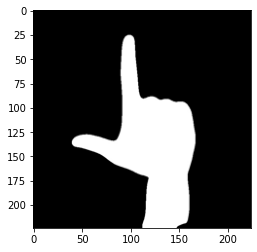

In [6]:
plt.imshow(X_data[0])

### Train-test split

In [7]:
X_train_rgb, X_test_rgb, y_train_rgb, y_test_rgb = train_test_split(X_data, y_data, test_size = 0.2, random_state=12, stratify=y_data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state=12, stratify=y_data)

### Building VGG model

In [ ]:
file_path = './model/VGG_saved-{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(filepath=file_path, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_acc',
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True)

In [ ]:
imageSize = 224
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = optimizers.Adam()

base_model = vgg_base  # Topless
# Add top layer
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc3')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', name='fc4')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Train top layers only
for layer in base_model.layers:
    layer.trainable = False

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_train, y_train), verbose=1,
          callbacks=[early_stopping, model_checkpoint])

In [8]:
# instead of training model above
from keras.models import load_model
model = load_model('model/VGG.h5')

In [9]:
def get_classification_metrics(X_test, y_test):
    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(confusion_matrix(y_true, pred))
    print('\n')
    print(classification_report(y_true, pred))

In [ ]:
get_classification_metrics(X_data, y_data)

In [ ]:
gesture_names = {0: 'C',
                 1: 'Fist',
                 2: 'L',
                 3: 'Okay',
                 4: 'Palm',
                 5: 'Peace'}

def predict_rgb_image(path):
    img2rgb = image_utils.load_img(path=path, target_size=(224, 224))
    img2rgb = image_utils.img_to_array(img2rgb)
    img2rgb = img2rgb.reshape(1, 224, 224, 3)
    return gesture_names[np.argmax(model.predict(img2rgb))]


In [ ]:
predict_rgb_image('test/palm.png')

### Building own model

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.25, seed=21))
model.add(layers.Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train[:500], y_train[:500], epochs=4, batch_size=64, validation_data=(X_test[:500], y_test[:500]), verbose=1, callbacks = [MetricsCheckpoint('logs')])

In [ ]:
model.fit(X_train_rgb, y_train_rgb, epochs=200, batch_size=16, validation_data=(X_test_rgb, y_test_rgb), verbose=1, callbacks =[early_stopping, model_checkpoint])

In [ ]:
def get_classification_reports(y_pred, y_true):
    y_pred_classes = np.array(np.argmax(y_pred))  # reconverts back from one hot encoded
    y_true = np.array(np.argmax(y_true))  # reconverts back from one hot encoded
    print(confusion_matrix(y_true, y_pred_classes))
    print(classification_report(y_true, y_pred_classes))
